<center><h1>Основы глубокого обучение</h1></center>

In [ ]:
!python -V # Версия Python

Python 3.12.10


In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
# import jupyterlab as jlab
# import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Версии необходимых библиотек
packages = [
    "Torch", "NumPy", "Polars", "Pandas", "Matplotlib", "Yfinance", "Scikit-learn", "NetworkX"
]

package_objects = [
    torch, np, pl, pd, mpl, yf, sklearn, nx
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""

    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.8.0+cu126"""
2,"""NumPy""","""2.0.2"""
3,"""Polars""","""1.25.2"""
4,"""Pandas""","""2.2.2"""
5,"""Matplotlib""","""3.10.0"""
6,"""Yfinance""","""0.2.66"""
7,"""Scikit-learn""","""1.6.1"""
8,"""NetworkX""","""3.5"""


# Лекция 3

3. **Классические архитектуры глубокого обучения для работы с последовательными данными.**
    - Обзор классических архитектур.

## Рекуррентные нейросети (Recurrent Neural Network - RNN)

### Описание

RNN предназначены для работы с последовательными данными, где порядок элементов имеет значение (текст, временные ряды, видео)

В отличие от полносвязных сетей, RNN имеют **циклические связи**, позволяя информации передаваться из одного временного шага к следующему

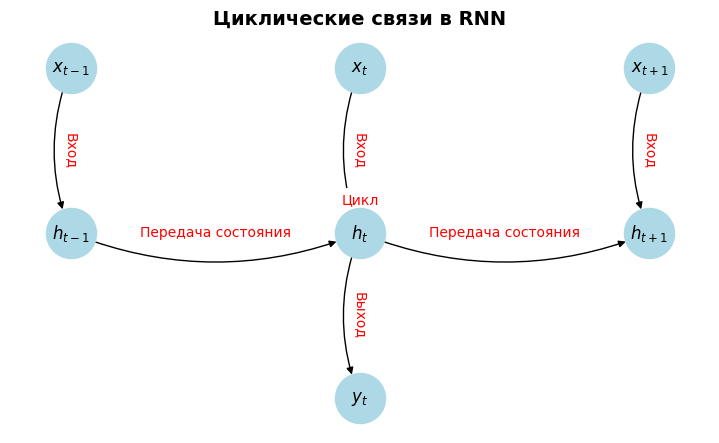

In [ ]:
def draw_rnn_diagram():
    G = nx.DiGraph()

    # Определение узлов (x - входы, h - скрытые состояния, y - выходы)
    nodes = ["$x_{t-1}$", "$x_t$", "$x_{t+1}$", "$h_{t-1}$", "$h_t$", "$h_{t+1}$", "$y_t$"]

    pos = {
        "$x_{t-1}$": (0, 1), "$x_t$": (2, 1), "$x_{t+1}$": (4, 1),
        "$h_{t-1}$": (0, 0), "$h_t$": (2, 0), "$h_{t+1}$": (4, 0),
        "$y_t$": (2, -1)
    }

    # Добавление узлов
    G.add_nodes_from(nodes)

    # Определение связей (ребра графа)
    edges = [
        ("$x_{t-1}$", "$h_{t-1}$"), ("$x_t$", "$h_t$"), ("$x_{t+1}$", "$h_{t+1}$"), # Вход -> скрытое состояние
        ("$h_{t-1}$", "$h_t$"), ("$h_t$", "$h_{t+1}$"), # Последовательная передача состояния
        ("$h_t$", "$y_t$"), # Выход
        ("$h_t$", "$h_t$") # Циклическая связь внутри h_t
    ]

    labels = {
        ("$x_{t-1}$", "$h_{t-1}$"): "Вход",
        ("$x_t$", "$h_t$"): "Вход",
        ("$x_{t+1}$", "$h_{t+1}$"): "Вход",
        ("$h_t$", "$y_t$"): "Выход",
        ("$h_t$", "$h_t$"): "Цикл",
        ("$h_{t-1}$", "$h_t$"): "Передача состояния",
        ("$h_t$", "$h_{t+1}$"): "Передача состояния",
    }

    G.add_edges_from(edges)

    # Граф
    plt.figure(figsize = (7, 4))
    nx.draw(
        G, pos, with_labels = True, node_color = "lightblue", edge_color = "black",
        node_size = 1300, font_size = 12, font_weight = "bold", arrows = True,
        connectionstyle = "arc3,rad=0.2"
    )
    edge_labels = {edge: labels[edge] for edge in labels if edge in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 10, font_color = "red")

    plt.title("Циклические связи в RNN", fontsize = 14, fontweight = "bold")
    plt.show()

draw_rnn_diagram()

### Математика RNN

> RNN обрабатывают последовательные данные, передавая информацию от одного временного шага к другому

#### Формула скрытого состояния

Основная идея RNN - это **сохранение памяти** о предыдущих состояниях через скрытое состояние $h_t$  

$$
h_t = \sigma(W_x x_t + W_h h_{t-1} + b_h)
$$

**Что это значит?**  
- $x_t$ - входные данные в момент времени $t$ (например, слово в предложении)
- $h_{t-1}$ - скрытое состояние на предыдущем шаге, несет информацию о прошлом
- $W_x$ - весовая матрица, отвечающая за обработку входных данных
- $W_h$ - весовая матрица, обрабатывающая прошлое скрытое состояние
- $b_h$ — смещение (bias), добавляемое к расчету
- $\sigma$ - функция активации, например, **tanh** или **ReLU**, которая ограничивает значения, предотвращая взрыв градиентов

**Простое объяснение.** RNN берет входные данные $x_t$ и предыдущее состояние $h_{t-1}$, взвешивает их с помощью $W_x$ и $W_h$, складывает и пропускает через функцию активации

#### Выходное значение

После обработки скрытого состояния можно получить выходные данные $y_t$

$$
y_t = W_y h_t + b_y
$$

где:  
- $W_y$ - весовая матрица выхода
- $b_y$ - смещение для выхода
- $y_t$ - выход модели (например, предсказанное следующее слово в предложении)

**Простое объяснение.** RNN берет скрытое состояние $h_t$ и переводит его в предсказание $y_t$ с помощью новой весовой матрицы $W_y$

### Весь процесс вместе

Если объединить обе формулы, будет:

$$
h_t = \sigma(W_x x_t + W_h h_{t-1} + b_h)
$$

$$
y_t = W_y h_t + b_y
$$

где:
- $h_t$ - передает информацию во времени (эффект памяти)
- $y_t$ - это выход в каждый момент времени
- $W_x, W_h, W_y$ - обучаемые параметры модели

### Абстрактная интерпретация  

- **RNN - это трубопровод**, в который поступает входной сигнал, а внутри происходит обработка и передача информации из прошлого
- **Память** - это скрытые состояния $h_t$, которые переносят информацию через последовательность

### Как обучать RNN?

#### Предположение

**Использовать обратное распространение ошибки (backpropagation), где градиенты вычисляются по цепному правилу и обновляются веса?**

#### Ответ

В RNN есть зависимость от предыдущих состояний, которые, в свою очередь, зависят от еще более ранних. Это создает временную зависимость, поэтому обычный backpropagation здесь не подойдет. Надо понять, как адаптировать его для последовательностей.

Использовать **Backpropagation Through Time (BPTT)**, которое является расширением обычного backpropagation и применяется к развернутой во времени RNN. RNN представляется в виде глубокой сети, где каждый слой соответствует определенному временному шагу. Тогда градиенты должны распространяться через все эти шаги.

##### **BPTT**

**Развертка RNN во времени**

RNN `разворачивается` в цепочку из $T$ шагов, где каждый шаг соответствует моменту времени $t$

**На каждом шаге**:
- **Скрытое состояние**: $h_t = \sigma(W_x x_t + W_h h_{t-1} + b_h)$
- **Выход**: $y_t = W_y h_t + b_y$
- **Общая потеря (cуммарная или кумулятивная)**: $L = \sum_{t=1}^T L_t(y_t, \hat{y}_t)$, при $\hat{y}_t$ - целевое значение

**Вычисление градиентов**

Градиенты вычисляются для параметров $W_x$, $W_h$, $W_y$, $b_h$, $b_y$ через цепное правило (от $t=T$ к $t=1$)

Для выходных параметров ($W_y$, $b_y$) производные вычисляются напрямую:
- $\frac{\partial L}{\partial W_y} = \sum_{t=1}^T \frac{\partial L_t}{\partial y_t} \times h_t^T$
- $\frac{\partial L}{\partial b_y} = \sum_{t=1}^T \frac{\partial L_t}{\partial y_t}$

Для скрытых параметров ($W_x$, $W_h$, $b_h$) градиенты зависят от всех предыдущих шагов

**На шаге $t$**:  
$
\frac{\partial L}{\partial h_t} = \underbrace{\frac{\partial L_t}{\partial y_t} \times W_y^T}_{\text{Градиент от текущего выхода}} + \underbrace{\frac{\partial L}{\partial h_{t+1}} \times \frac{\partial h_{t+1}}{\partial h_t}}_{\text{Градиент от будущего}}
$

где:
- **Градиент от текущего выхода $y_t$:**  
    - $\frac{\partial L_t}{\partial y_t}$: Насколько текущая ошибка $L_t$ (например, MSE или кросс-энтропия) зависит от вывода $y_t$
    - $W_y^T$: Транспонированная матрица весов $W_y$ `переносит` градиент от выхода $y_t$ обратно к скрытому состоянию $h_t$
    - **Пример:** Если $y_t$ - предсказанное слово, а $L_t$ - ошибка предсказания, то градиент от текущего выхода показывает, как корректировать $h_t$, чтобы улучшить текущее предсказание
- **Градиент от будущего $h_{t+1}$:**  
    - $\frac{\partial L}{\partial h_{t+1}}$: Градиент общей ошибки $L$ от **следующего** скрытого состояния $h_{t+1}$
    - $\frac{\partial h_{t+1}}{\partial h_t}$: Насколько $h_{t+1}$ зависит от $h_t$. Это **рекуррентная связь** во времени
    - **Пример:** Если $h_t$ влияет на $h_{t+1}$ (например, в предложении: текущее слово влияет на следующее), то градиент от будущего передает градиент в прошлое

#### Проблемы BPTT

##### 1. Затухающие/взрывающиеся градиенты
- При умножении производных $\frac{\partial h_{t+1}}{\partial h_t}$ градиенты:  
    - **Экспоненциально затухают**, если $|W_h| < 1$ (пример: $W_h = 0.5$ с активацией `tanh`)
    - **Взрываются**, если $|W_h| > 1$ (пример: $W_h = 2$)

##### 2. Вычислительная сложность
- Обработка длинных последовательностей требует больших ресурсов

#### Решения
1. **Усеченный BPTT (Truncated BPTT).** Градиенты распространяются на $k$ шагов назад (например, $k=10$)
2. **LSTM/GRU**
3. **Нормализация градиентов.** Ограничение градиентов по величине (gradient clipping)

| **Параметр**          | **Truncated BPTT**                 | **Gradient Clipping**                |
|-----------------------|------------------------------------|--------------------------------------|
| **Основная идея**     | Усечение шагов для BPTT            | Ограничение величины градиентов      |
| **Скорость обучения** | Быстрее (меньше шагов)             | Медленнее (полный BPTT)              |
| **Стабильность**      | Меньше контроль над градиентами    | Лучший контроль взрывов градиентов   |
| **Реализация**        | Модификация цикла `reversed(range)`| Манипуляции с градиентами после BPTT |

### Долгая кратковременная память (Long Short-Term Memory - LSTM)

#### Описание

LSTM - это разновидность RNN, предназначенная для работы с последовательными данными, но с механизмом управления памятью, позволяющим эффективно сохранять долгосрочные зависимости

В отличие от классических RNN, LSTM использует специальные **элементы памяти (ячейки) и механизм управляющих ворот**, который контролирует поток информации внутри сети

### Математика LSTM

> LSTM улучшает RNN, добавляя механизмы управления памятью через специальные ворота

#### Формула обновления памяти

В отличие от RNN, LSTM имеет **ячейку памяти** $c_t$, которая передает долгосрочную информацию через последовательность

Обновление памяти:

$$
c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t
$$

где:
- $c_t$ - обновленное состояние памяти
- $c_{t-1}$ - предыдущее состояние памяти
- $\tilde{c}_t$ - новая кандидатная память
- $f_t$ - коэффициент забывания (**forget gate**)
- $i_t$ - коэффициент обновления (**input gate**)
- $\odot$ - покоординатное умножение  

#### Ворота управления

LSTM использует три специальных **ворота**:

1. **Ворота забывания** решают, сколько информации удалить из памяти:

   $$
   f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)
   $$

2. **Ворота входа** решают, сколько новой информации добавить:

   $$
   i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)
   $$

3. **Ворота выхода** решают, что пропустить в скрытое состояние:

   $$
   o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)
   $$

#### Обновление скрытого состояния

Скрытое состояние $h_t$ обновляется на основе нового состояния памяти $c_t$ и выхода:

$$
h_t = o_t \odot \tanh(c_t)
$$

где:
- $\tanh(c_t)$ - нормализованное состояние памяти
- $o_t$ - решает, какая часть памяти пойдет в выход

#### Выходное значение

Выходное значение $y_t$ вычисляется аналогично RNN:

$$
y_t = W_y h_t + b_y
$$

где:
- $W_y$ - матрица весов выхода
- $b_y$ - смещение выхода

### Весь процесс вместе

1. Вычисляются ворота $f_t$, $i_t$, $o_t$
2. Обновляется состояние памяти $c_t$
3. Обновляется скрытое состояние $h_t$
4. Вычисляется выход $y_t$

### Абстрактная интерпретация  

- **LSTM решает проблему забывания в RNN** с помощью контролируемой памяти
- **Три ворота** позволяют динамически фильтровать, что забывать, что запоминать и что выводить
- **Ячейка памяти $c_t$** передает информацию через последовательность, снижая влияние взрывающихся градиентов

### Как обучать LSTM?

#### Предположение

**Использовать обратное распространение ошибки (backpropagation), где градиенты вычисляются по цепному правилу и обновляются веса?**

#### Ответ

Так как LSTM имеет более сложную структуру с несколькими вратами, обычный backpropagation также не подходит напрямую. Нужно применять **Backpropagation Through Time (BPTT)**, но с учетом специфики LSTM

##### **BPTT для LSTM**

**Развертка LSTM во времени**

LSTM `разворачивается` в цепочку из $T$ шагов, где каждый шаг соответствует моменту времени $t$

**На каждом шаге**:
- **Состояние памяти:** $c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$
- **Скрытое состояние:** $h_t = o_t \odot \tanh(c_t)$
- **Выход:** $y_t = W_y h_t + b_y$
- **Потеря:** $L = \sum_{t=1}^T L_t(y_t, \hat{y}_t)$

**Вычисление градиентов**

Градиенты вычисляются через цепное правило, начиная с конечного момента $t=T$ и двигаясь назад:

Для выхода:
- $\frac{\partial L}{\partial W_y} = \sum_{t=1}^T \frac{\partial L_t}{\partial y_t} \times h_t^T$
- $\frac{\partial L}{\partial b_y} = \sum_{t=1}^T \frac{\partial L_t}{\partial y_t}$

Для скрытого состояния $h_t$:

$$
\frac{\partial L}{\partial h_t} = \frac{\partial L_t}{\partial y_t} \times W_y^T + \frac{\partial L}{\partial h_{t+1}} \times \frac{\partial h_{t+1}}{\partial h_t}
$$

В LSTM скрытое состояние $h_t$ зависит от состояния памяти $c_t$, поэтому необходимо дополнительно учитывать производную по $c_t$:

$$
\frac{\partial L}{\partial c_t} = \frac{\partial L}{\partial h_t} \odot o_t \odot (1 - \tanh^2(c_t)) + \frac{\partial L}{\partial c_{t+1}} \odot f_{t+1}
$$

Градиенты врат:
- **Ворота забывания:**  
  $$
  \frac{\partial L}{\partial f_t} = \frac{\partial L}{\partial c_t} \odot c_{t-1}
  $$
- **Ворота входа:**  
  $$
  \frac{\partial L}{\partial i_t} = \frac{\partial L}{\partial c_t} \odot \tilde{c}_t
  $$
- **Ворота выхода:**  
  $$
  \frac{\partial L}{\partial o_t} = \frac{\partial L}{\partial h_t} \odot \tanh(c_t)
  $$
- **Кандидатная память:**  
  $$
  \frac{\partial L}{\partial \tilde{c}_t} = \frac{\partial L}{\partial c_t} \odot i_t
  $$

#### Проблемы BPTT в LSTM

##### 1. Вычислительная сложность

- LSTM имеет больше параметров, чем RNN, из-за наличия нескольких врат
- Вычисление градиентов требует больше памяти

##### 2. Все еще возможны затухающие градиенты

- Хотя LSTM **уменьшает** проблему затухающих градиентов благодаря состоянию памяти $c_t$, они все же могут возникать при плохом выборе гиперпараметров

##### 3. Сложность параллелизации

- В отличие от трансформеров, BPTT в LSTM зависит от последовательности, что затрудняет параллельные вычисления

#### Решения

1. **Усеченный BPTT (Truncated BPTT).** Обучение на фиксированном числе временных шагов (например, $k=10$)
2. **Gradient Clipping.** Ограничение максимальной величины градиента
3. **Использование более эффективных архитектур** (например, GRU или трансформеров)

### Управляемый рекуррентный блок (Gated Recurrent Unit - GRU)

#### Описание  

**GRU** - это модификация RNN, разработанная для эффективного моделирования долгосрочных зависимостей в последовательных данных. Как и LSTM, GRU решает проблему затухающих градиентов, но с более компактной архитектурой.

### Математика GRU

> GRU упрощает архитектуру LSTM, сохраняя способность управлять долгосрочными зависимостями

#### Формула обновления скрытого состояния

GRU использует **единое скрытое состояние** $h_t$, объединяющее функции памяти и вывода:

Обновление состояния:

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

где:
- $h_t$ - новое скрытое состояние
- $h_{t-1}$ - предыдущее скрытое состояние
- $\tilde{h}_t$ - кандидатское состояние
- $z_t$ - коэффициент обновления (**update gate**)
- $\odot$ - покоординатное умножение

#### Ворота управления

GRU использует **два ворта** вместо трех:

1. **Ворота обновления (Update Gate)**
   Определяют баланс между старым и новым состоянием:

   $$
   z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
   $$

3. **Ворота сброса (Reset Gate)**  
   Управляют влиянием предыдущего состояния на кандидатское:

   $$
   r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
   $$

#### Кандидатское состояние

Формируется с учетом `сброшенного` предыдущего состояния:

$$
\tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
$$

где:
- $r_t \odot h_{t-1}$ - фильтрация нерелевантной информации из прошлого
- $\tanh$ - нелинейность для генерации нового кандидата

#### Выходное значение

Выход $y_t$ совпадает с обновленным скрытым состоянием (в отличие от LSTM):

$$
y_t = h_t
$$

#### Весь процесс вместе

1. Вычисляются ворота $z_t$, $r_t$
2. Формируется кандидатское состояние $\tilde{h}_t$
3. Обновляется скрытое состояние $h_t$ через интерполяцию старого и нового
4. Выход $y_t$ равен $h_t$

### Абстрактная интерпретация

- **GRU решает проблему долгосрочных зависимостей** через адаптивное смешивание состояний:
    - **Ворота обновления** ($z_t$): `Сколько информации сохранить из прошлого?`
    - **Ворота сброса** ($r_t$): `Какую часть истории игнорировать при генерации нового состояния?`
- **Ключевые упрощения** относительно LSTM:
    - Нет отдельной ячейки памяти ($c_t$ и $h_t$ объединены)
    - Отсутствуют ворота выхода ($o_t$)
    - Динамическое обновление через линейную интерполяцию вместо сложных взаимодействий
- **Эффективность**: меньше параметров -> быстрее обучение, меньше риск переобучения. Часто превосходит LSTM на коротких и средних последовательностях

### Как обучать GRU?

#### Предположение

**Использовать обратное распространение ошибки (backpropagation) с цепным правилом?** Да, но из-за рекуррентной природы требуется адаптация метода для последовательностей

#### Ответ

GRU обучается с помощью **Backpropagation Through Time (BPTT)**, как и LSTM, но с упрощениями благодаря компактной архитектуре

##### **BPTT для GRU**

**Развертка GRU во времени**

Сеть разворачивается в цепочку из $T$ шагов. На каждом шаге $t$:

- **Ворота обновления и сброса:**

  $$
  z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z), \quad r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
  $$

- **Кандидатское состояние:**

  $$
  \tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)
  $$

- **Скрытое состояние:**

  $$
  h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
  $$

- **Выход:**

  $$
  y_t = h_t \quad (\text{или } y_t = W_y h_t + b_y \text{ при дополнительном слое})
  $$

- **Потеря:**

  $$
  L = \sum_{t=1}^T L_t(y_t, \hat{y}_t)
  $$

**Вычисление градиентов**

Градиенты распространяются от $t=T$ к $t=1$:

Для выхода (если используется отдельный слой):

$$
\frac{\partial L}{\partial W_y} = \sum_{t=1}^T \frac{\partial L_t}{\partial y_t} \times h_t^T, \quad \frac{\partial L}{\partial b_y} = \sum_{t=1}^T \frac{\partial L_t}{\partial y_t}
$$

Для скрытого состояния $h_t$:

$$
\frac{\partial L}{\partial h_t} = \frac{\partial L_t}{\partial y_t} + \frac{\partial L}{\partial h_{t+1}} \times \frac{\partial h_{t+1}}{\partial h_t}
$$

Производные компонентов:

- **Ворота обновления ($z_t$):**

  $$
  \frac{\partial L}{\partial z_t} = \frac{\partial L}{\partial h_t} \odot (\tilde{h}_t - h_{t-1})
  $$

- **Ворота сброса ($r_t$):**

  $$
  \frac{\partial L}{\partial r_t} = \frac{\partial L}{\partial \tilde{h}_t} \odot U_h^T (h_{t-1} \odot (1 - \tilde{h}_t^2))
  $$

- **Кандидатское состояние ($\tilde{h}_t$):**

  $$
  \frac{\partial L}{\partial \tilde{h}_t} = \frac{\partial L}{\partial h_t} \odot z_t \odot (1 - \tilde{h}_t^2)
  $$

#### Проблемы BPTT в GRU

##### 1. Умеренная вычислительная сложность

- Меньше параметров, чем у LSTM (нет отдельной ячейки памяти), но все равно требует сохранения промежуточных состояний для всех $t$

##### 2. Риск затухающих градиентов

- GRU смягчает проблему затухания через адаптивные ворота, но длинные последовательности все еще могут вызывать исчезновение градиентов

##### 3. Ограничения параллелизации

- Как и все RNN, GRU требует последовательной обработки шагов, что замедляет обучение на GPU

#### Решения

1. **Усеченный BPTT (Truncated BPTT):**  
   Ограничение глубины обратного распространения (например, 20 шагов)
2. **Gradient Clipping:**  
   Ограничение нормы градиентов для предотвращения взрывов:
   $$
   \text{grad} = \frac{\text{grad} \cdot \text{threshold}}{\max(\|\text{grad}\|, \text{threshold})}
   $$
3. **Пакетная обработка (Batching):**  
   Параллельная обработка независимых последовательностей в мини-пакетах
4. **Использование оптимизаторов:**  
   Adam или AdamW для адаптивного шага обучения

### Абстрактная интерпретация

- **GRU балансирует между сложностью и эффективностью:** меньше параметров -> быстрее сходимость, но требует аккуратной настройки ворот
- **Динамическое обновление состояний:** ворота $z_t$ и $r_t$ автоматически регулируют `память` сети, минимизируя ручной подбор гиперпараметров
- **Устойчивость к шуму:** механизм сброса ($r_t$) фильтрует нерелевантную историю, улучшая обобщение

# Семинар 3

3. **Классические архитектуры глубокого обучения для работы с последовательными данными.**
    - Применение классических архитектур для анализа последовательных данных.

## Процесс обучения RNN

In [6]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))

    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]

    def backward(self, inputs, target, lr = 0.001):
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])

        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy

        dh = self.W_hy.T @ dy + dh_next
        for t in reversed(range(len(inputs))):
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]

            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh

            dh = self.W_hh.T @ dtanh

        clip_value = 5.0
        for grad in [dW_xh, dW_hh, dW_hy]:
            np.clip(grad, -clip_value, clip_value, out = grad)

        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y

# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]

        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()

        rnn.backward(inputs, target, lr)

    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования
def forecast(model, last_sequence, days = 30):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq.reshape(-1, 1))
    real = scaler.inverse_transform(y_test[idx].reshape(-1, 1))
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов
ax6 = plt.subplot2grid((4, 4), (2, 0))
lag_importance = np.mean(np.abs(rnn.W_xh), axis = 0)
ax6.bar(range(seq_length), lag_importance, color = plt.cm.viridis(np.linspace(0,1,seq_length)))
ax6.set_title("Важность временных лагов", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов
ax10 = plt.subplot2grid((4, 4), (3, 1))
gradients = np.concatenate([rnn.W_xh.flatten(), rnn.W_hh.flatten()])
ax10.hist(gradients, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура RNN:
- Вход: 1 нейрон
- Скрытый слой: 32 нейрона
- Активация: tanh
- Обучение: 100 эпох
- Оптимизатор: SGD
- LR: 0.001
- Длина последовательности: 60 дней"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

1649

### Руководство по интерпретации графиков

#### 1. Динамика обучения

**Что показывает:**
- Изменение величины ошибки (MSE) в процессе обучения
- Скорость и стабильность сходимости модели

**Как смотреть:**
- ✔️ Хорошо: Плавное уменьшение ошибки
- ⚠️ Плохо:
    - Резкие скачки ошибки
    - Отсутствие снижения после N эпох
    - Рост ошибки на поздних этапах

#### 2. Реальные и предсказанные значения

**Что показывает:**
- Точность модели в сравнении с идеальным прогнозом (красная пунктирная линия)
- Распределение ошибок (цвет точек)

**Как смотреть:**
- Чем ближе точки к диагонали - тем лучше
- Скопления точек в определенных областях указывают на систематические ошибки
- Яркие желтые точки - наибольшие ошибки прогнозирования

#### 3. Распределение ошибок

**Что показывает:**
- Статистику ошибок прогнозирования
- Смещение и форму распределения

**Как смотреть:**
- ✔️ Хорошо:
    - Распределение близко к нормальному
    - Пик около нуля
- ⚠️ Плохо:
    - Явное смещение в положительную/отрицательную сторону

#### 4. Скользящее среднее и волатильность

**Что показывает:**
- Основной тренд (синяя линия)
- Изменчивость цен (зеленая линия)
- Историческую динамику

**Как смотреть:**
- Пересечения цены и скользящего среднего - возможные точки разворота тренда
- Высокая волатильность - периоды нестабильности рынка

#### 5. Примеры прогнозов

**Что показывает:**
- Конкретные примеры работы модели:
    - Пунктирные линии: исторические данные
    - Красные точки: реальные значения
    - Зеленые точки: предсказания модели

**Как смотреть:**
- Сравнивать положение красных и зеленых точек  
- Анализировать, как модель реагирует на разные шаблоны

#### 6. Важность временных лагов

**Что показывает:**
- Значимость предыдущих дней для прогноза
- Какие исторические данные наиболее важны

**Как смотреть:**
- Высокие столбцы справа - модель учитывает недавние данные  
- Пики в определенных позициях - ключевые исторические события  

#### 7. Автокорреляция ошибок

**Что показывает:**
- Наличие шаблонов в ошибках прогнозирования
- Зависимость ошибок от предыдущих значений

**Как смотреть:**
- ✔️ Хорошо: Нет значимых корреляций (все значения в синей зоне)  
- ⚠️ Плохо:  
    - Выбросы за пределы доверительного интервала  
    - Повторяющиеся шаблоны

#### 8. 30-дневный прогноз

**Что показывает:**
- Предсказание модели на следующий месяц
- Точки прогноза с датами

**Как смотреть:**
- Анализировать общий тренд (рост/падение)
- Отмечайте резкие изменения направления
- Сравнить с текущими рыночными ожиданиями

#### 9. 3D визуализация tanh

**Что показывает:**  
- Поведение функции активации в трехмерном пространстве  
- Нелинейные свойства используемой активации  

**Как смотреть:**
- S-образная форма - характерная особенность tanh
- Значения в диапазоне $[-1, 1]$ - ограничение выходных значений

#### 10. Распределение весов

**Что показывает:**
- Статистику значений параметров модели
- Сбалансированность обучения

**Как смотреть:**
- ✔️ Хорошо: Симметричное распределение около нуля
- ⚠️ Плохо:
    - Смещенные распределения
    - Выбросы в крайних значениях

### Использование усеченного BPTT (Truncated BPTT)

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.082577
Epoch 10, Loss: 0.082577
Epoch 20, Loss: 0.082577
Epoch 30, Loss: 0.082577
Epoch 40, Loss: 0.082577
Epoch 50, Loss: 0.082577
Epoch 60, Loss: 0.082577
Epoch 70, Loss: 0.082577
Epoch 80, Loss: 0.082577
Epoch 90, Loss: 0.082577


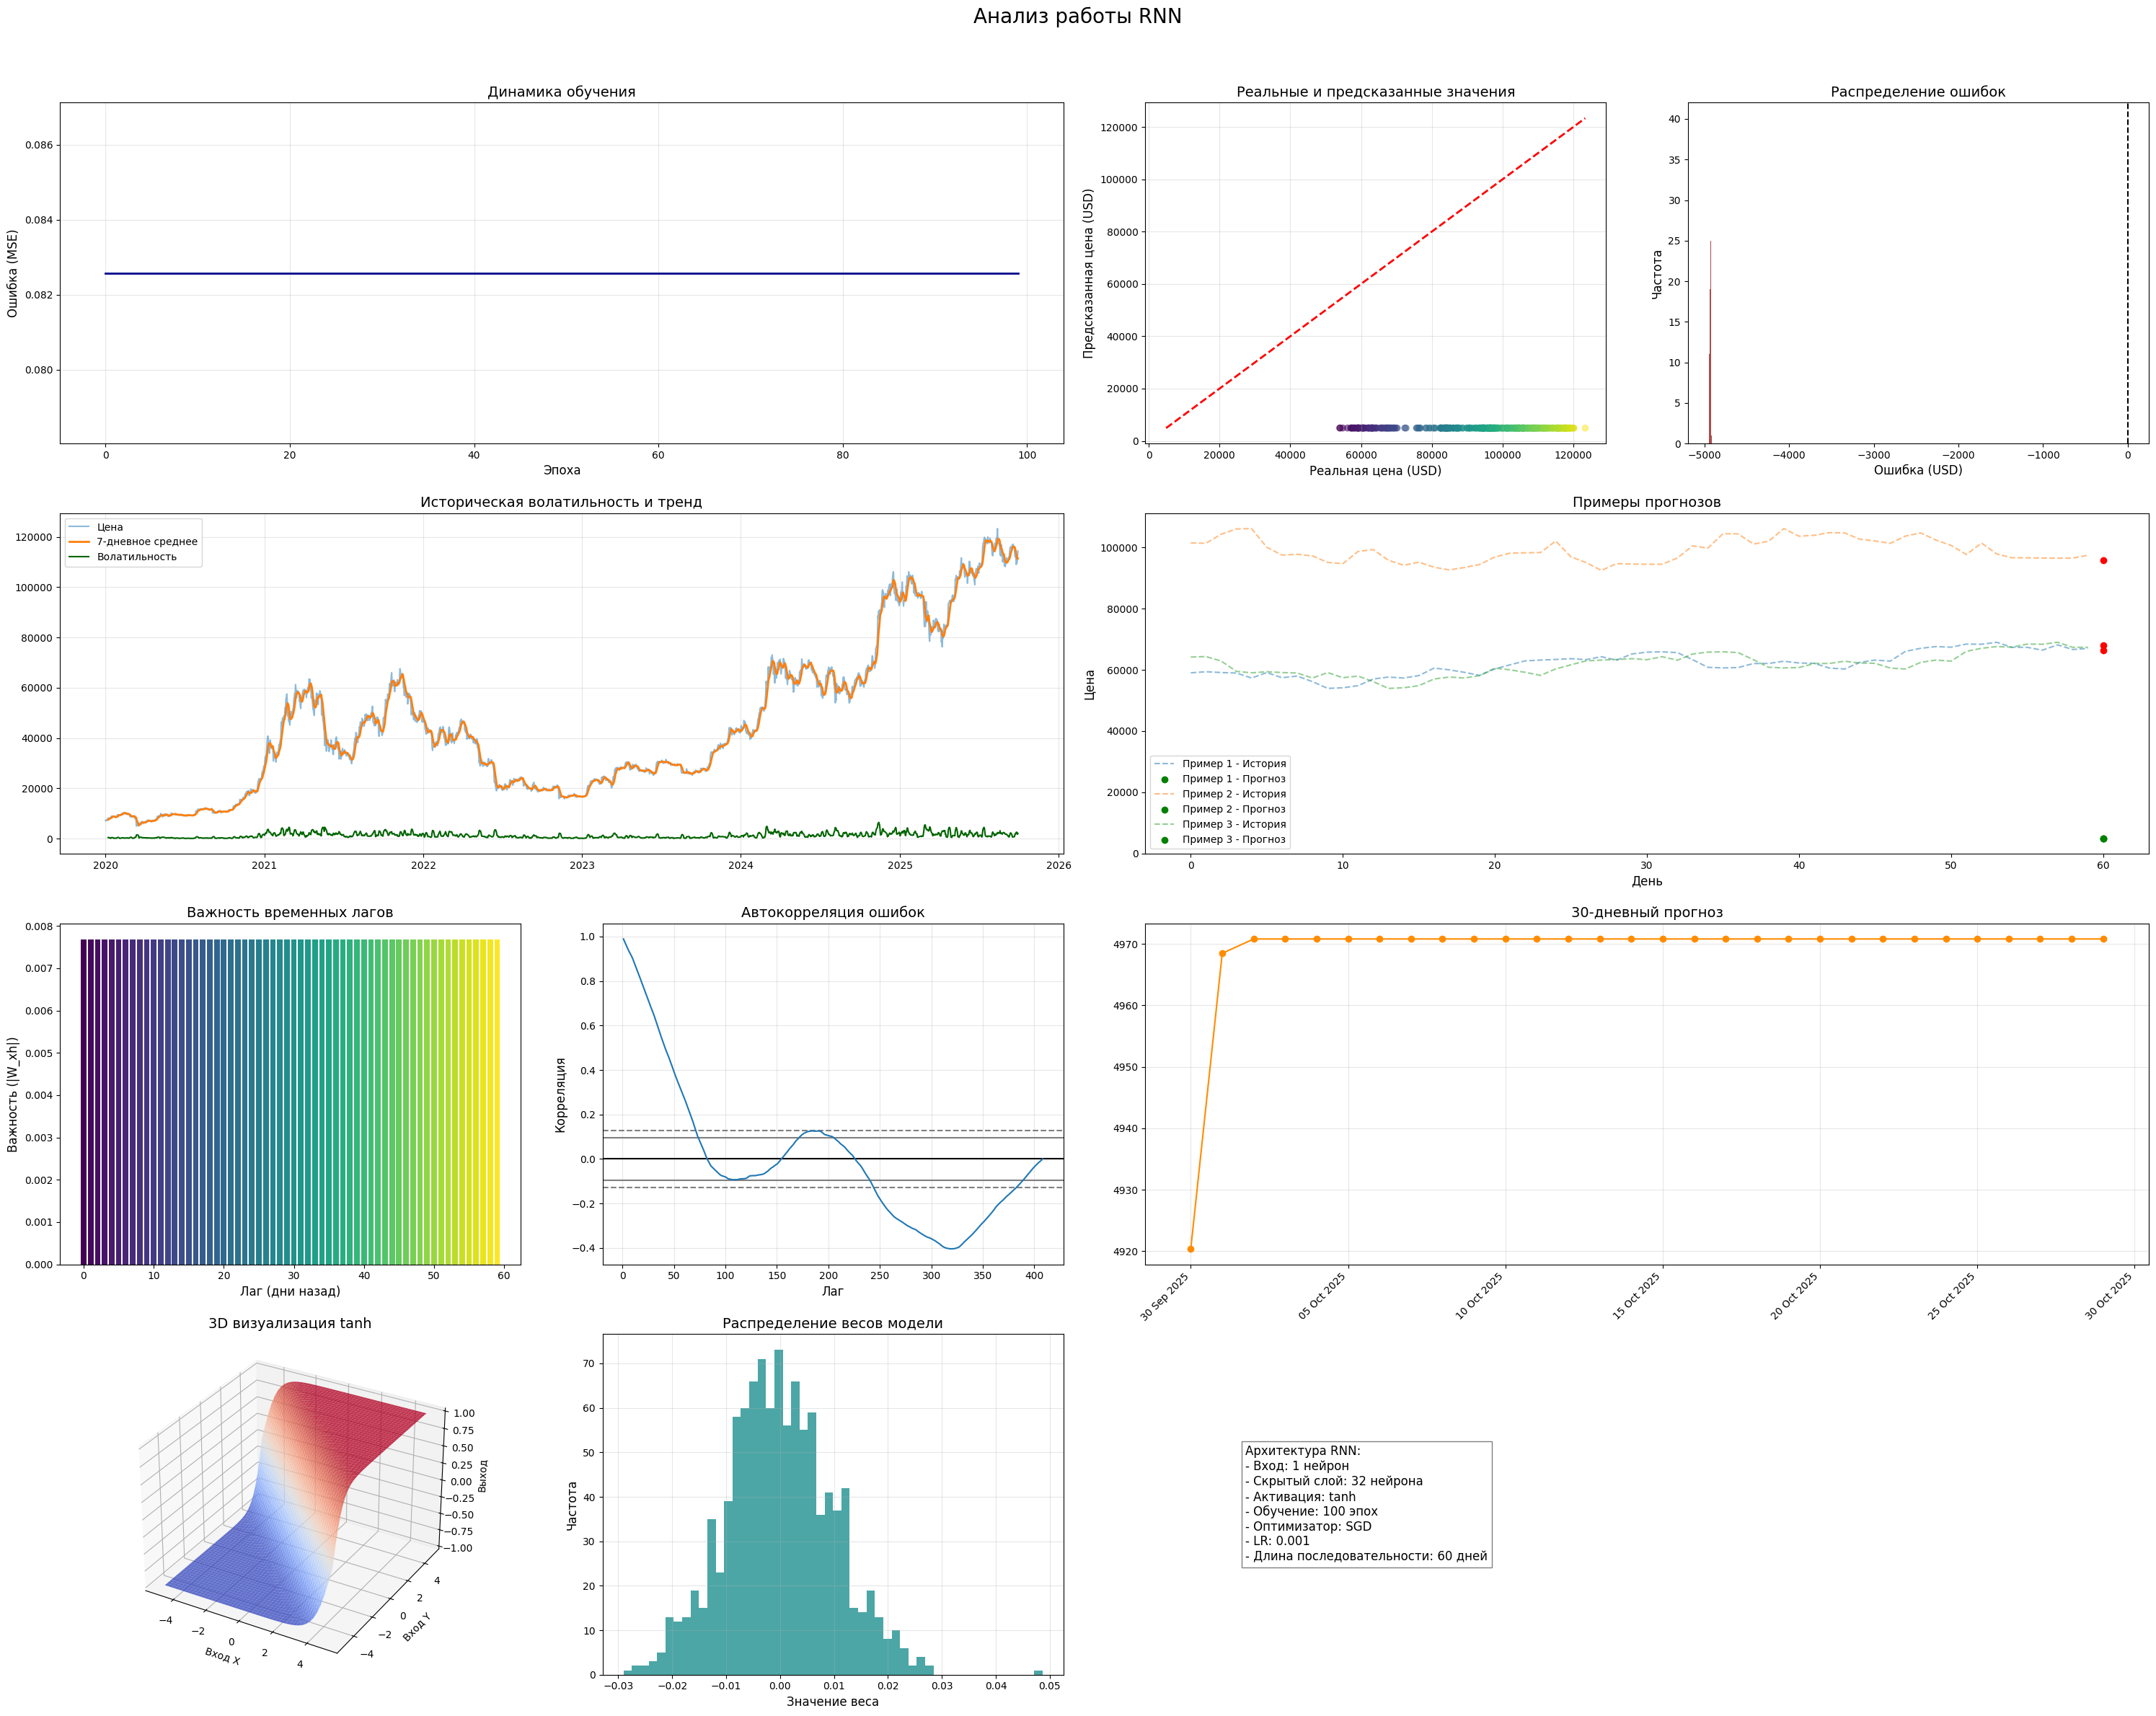

In [ ]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))

    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]

    def backward(self, inputs, target, lr=0.001, truncate_steps = 10): # Изменение 1: Добавлен параметр
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])

        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy

        dh = self.W_hy.T @ dy + dh_next

        # Изменение 2: Ограничение диапазона шагов для BPTT
        start_step = max(0, len(inputs) - truncate_steps)
        for t in reversed(range(start_step, len(inputs))): # Только последние truncate_steps шагов
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]

            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh

            dh = self.W_hh.T @ dtanh

# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]

        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()

        # Изменение 3: Передаем truncate_steps в backward
        rnn.backward(inputs, target, lr, truncate_steps = 10) # Усечение на 10 шагов

    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования
def forecast(model, last_sequence, days = 30):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq.reshape(-1, 1))
    real = scaler.inverse_transform(y_test[idx].reshape(-1, 1))
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов
ax6 = plt.subplot2grid((4, 4), (2, 0))
lag_importance = np.mean(np.abs(rnn.W_xh), axis = 0)
ax6.bar(range(seq_length), lag_importance, color = plt.cm.viridis(np.linspace(0,1,seq_length)))
ax6.set_title("Важность временных лагов", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов
ax10 = plt.subplot2grid((4, 4), (3, 1))
gradients = np.concatenate([rnn.W_xh.flatten(), rnn.W_hh.flatten()])
ax10.hist(gradients, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура RNN:
- Вход: 1 нейрон
- Скрытый слой: 32 нейрона
- Активация: tanh
- Обучение: 100 эпох
- Оптимизатор: SGD
- LR: 0.001
- Длина последовательности: 60 дней"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

### Нормализация градиентов

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.035878
Epoch 10, Loss: 0.021997
Epoch 20, Loss: 0.021838
Epoch 30, Loss: 0.021551
Epoch 40, Loss: 0.020985
Epoch 50, Loss: 0.019860
Epoch 60, Loss: 0.017677
Epoch 70, Loss: 0.013725
Epoch 80, Loss: 0.007740
Epoch 90, Loss: 0.002124


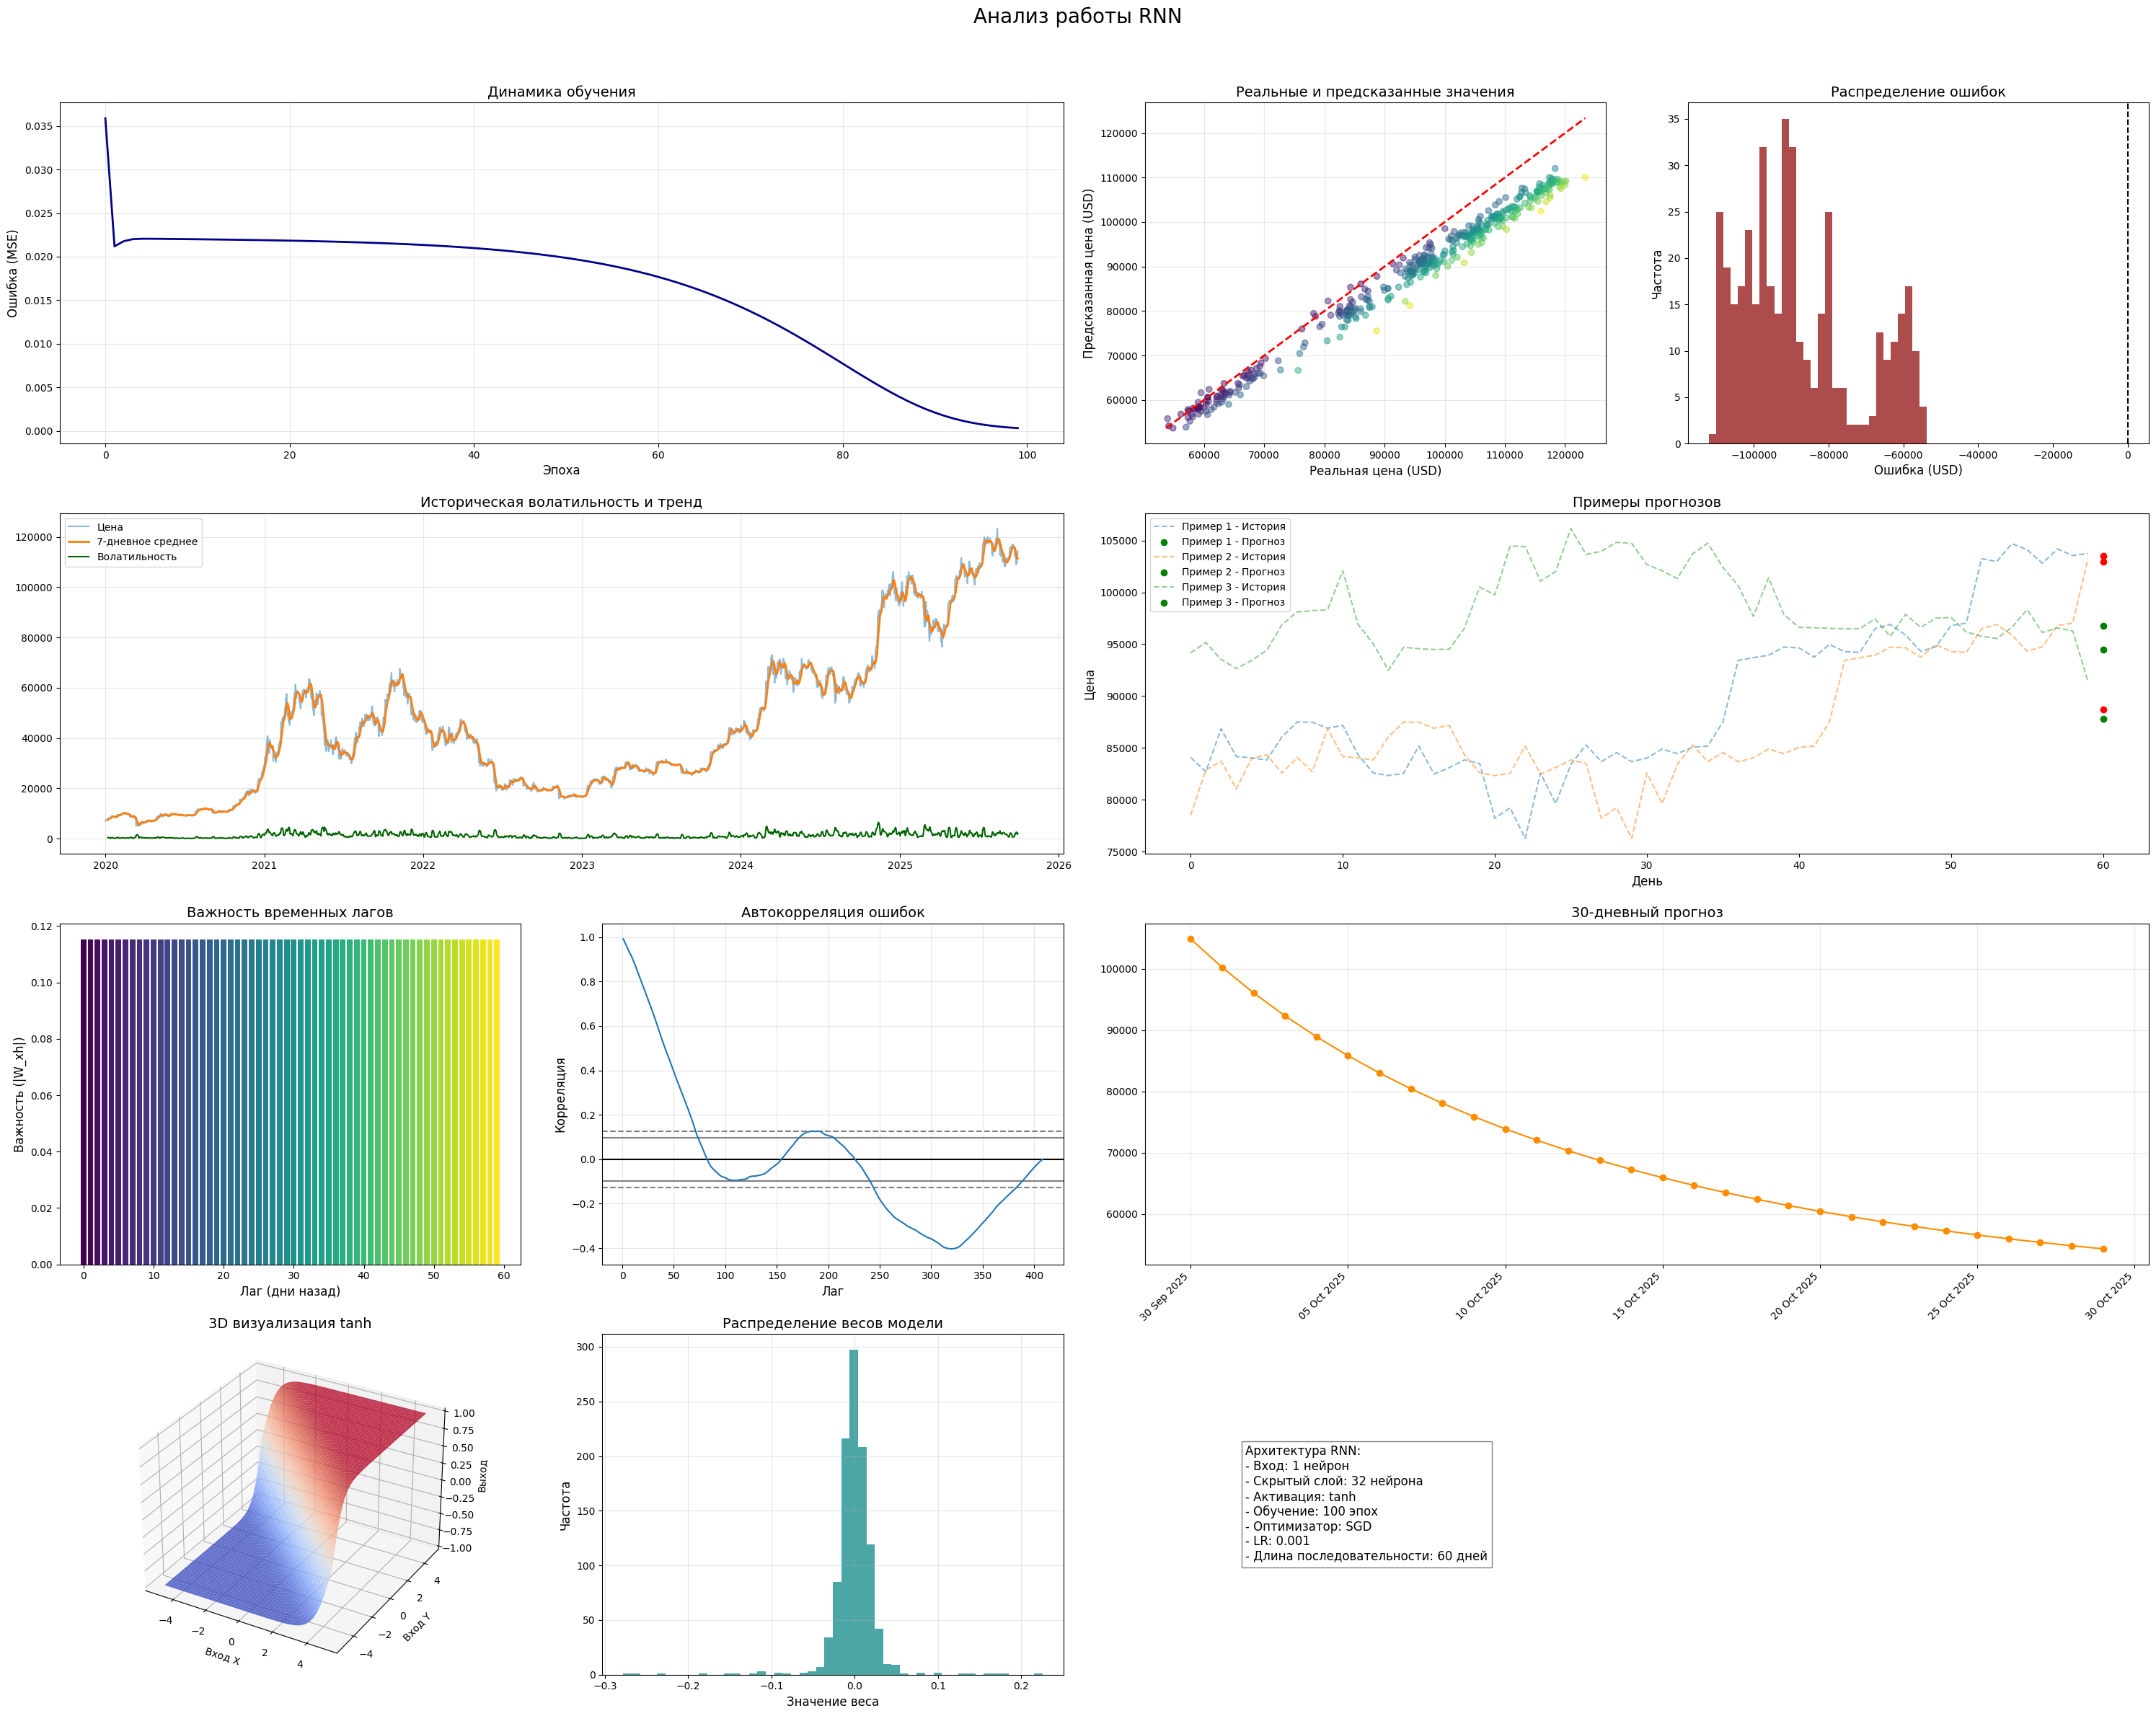

In [ ]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end = pd.Timestamp.now().strftime('%Y-%m-%d'))
data = data[['Close']]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))

    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]

    def backward(self, inputs, target, lr=0.001, clip_norm=5.0): # Изменение 1: clip_norm вместо truncate_steps
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])

        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy

        dh = self.W_hy.T @ dy + dh_next

        # Изменение 2: Возвращение полного BPTT без усечения шагов
        for t in reversed(range(len(inputs))): # Обработка всех шагов
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]

            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh

            dh = self.W_hh.T @ dtanh

        # Изменение 3: Gradient Clipping по L2-норме
        grads = [dW_xh, dW_hh, db_h, dW_hy, db_y]
        global_norm = np.sqrt(sum(np.sum(g**2) for g in grads)) # Подсчет общей нормы

        if global_norm > clip_norm:
            scale = clip_norm / global_norm
            for g in grads:
                g *= scale # Масштабирование всех градиентов

        # Обновление весов (без изменений)
        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y

# Параметры модели
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

rnn = SimpleRNN(input_size, hidden_size)

# Обучение модели
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X_train)):
        inputs = X_train[i].reshape(-1, 1)
        target = y_train[i]

        output = rnn.forward(inputs)
        loss = (output - target.reshape(-1, 1)) ** 2
        epoch_loss += loss.item()

        # Изменение 4: Вызов backward без параметра truncate_steps
        rnn.backward(inputs, target, lr, clip_norm = 5.0) # clip_norm вместо truncate_steps

    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Функция прогнозирования
def forecast(model, last_sequence, days = 30):
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(days):
        next_pred = model.forward(current_seq)
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred)
    return predictions

# Генерация предсказаний на тестовых данных
test_predictions = []
for i in range(len(X_test)):
    inputs = X_test[i].reshape(-1, 1)
    output = rnn.forward(inputs)
    test_predictions.append(output.item())

# Преобразование предсказаний обратно в исходный масштаб цен
test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Прогноз на N дней
last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
scaled_forecast = forecast(rnn, last_sequence, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы RNN", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(loss_history, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(y_test_inv - test_predictions_inv), cmap = "viridis")

min_val = min(y_test_inv.min(), test_predictions_inv.min())
max_val = max(y_test_inv.max(), test_predictions_inv.max())
ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test - test_predictions_inv
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx]
    pred = rnn.forward(seq.reshape(-1, 1))
    real = scaler.inverse_transform(y_test[idx].reshape(-1, 1))
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов
ax6 = plt.subplot2grid((4, 4), (2, 0))
lag_importance = np.mean(np.abs(rnn.W_xh), axis = 0)
ax6.bar(range(seq_length), lag_importance, color = plt.cm.viridis(np.linspace(0,1,seq_length)))
ax6.set_title("Важность временных лагов", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов
ax10 = plt.subplot2grid((4, 4), (3, 1))
gradients = np.concatenate([rnn.W_xh.flatten(), rnn.W_hh.flatten()])
ax10.hist(gradients, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура RNN:
- Вход: 1 нейрон
- Скрытый слой: 32 нейрона
- Активация: tanh
- Обучение: 100 эпох
- Оптимизатор: SGD
- LR: 0.001
- Длина последовательности: 60 дней"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

## Процесс обучения LSTM

In [ ]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.FloatTensor(X), torch.FloatTensor(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Определение LSTM модели
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinLSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Обучение модели
num_epochs = 100
train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i in range(len(X_train)):
        inputs = X_train[i].unsqueeze(0)
        target = y_train[i].unsqueeze(0)

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(X_train)
    train_loss.append(avg_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

# Прогнозирование
def forecast(model, sequence, days = 30):
    current_seq = sequence.squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        predictions.append(pred.item())
        current_seq = torch.cat((current_seq[1:], pred))
    return predictions

# Генерация прогноза
last_sequence = scaled_data[-seq_length:]
input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0)
scaled_forecast = forecast(model, input_tensor, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Преобразование предсказаний и тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0))
        test_predictions.append(pred.item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы LSTM", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(train_loss, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha = 0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_original, test_predictions, alpha = 0.5, c = np.abs(y_test_original - test_predictions), cmap = "viridis", s = 40)
ax2.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "--r", linewidth = 2)
ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_original - test_predictions
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = scaler.inverse_transform(y_test[idx].numpy().reshape(-1, 1))

    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred.numpy()), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена (USD)", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов (адаптированная для LSTM)
ax6 = plt.subplot2grid((4, 4), (2, 0))
# Получаем веса входного слоя LSTM
lstm_weights = model.lstm.weight_ih_l0.detach().numpy()
# Средние значения весов по всем нейронам
lag_importance = np.mean(np.abs(lstm_weights[:model.hidden_size]), axis = 0)
ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))
ax6.set_title("Важность временных лагов (первые входные веса)", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура LSTM:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (вход/состояние), sigmoid (ворота)
- Обучение: 20 эпох
- Оптимизатор: Adam
- LR: 0.001
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.000690
Epoch 10, Loss: 0.006227


KeyboardInterrupt: 

## Процесс обучения GRU

In [7]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.FloatTensor(X), torch.FloatTensor(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Определение GRU модели
class BitcoinGRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinGRU()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Обучение модели
num_epochs = 20
train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i in range(len(X_train)):
        inputs = X_train[i].unsqueeze(0)
        target = y_train[i].unsqueeze(0)

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(X_train)
    train_loss.append(avg_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

# Прогнозирование
def forecast(model, sequence, days = 30):
    current_seq = sequence.squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        predictions.append(pred.item())
        current_seq = torch.cat((current_seq[1:], pred))
    return predictions

# Генерация прогноза
last_sequence = scaled_data[-seq_length:]
input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0)
scaled_forecast = forecast(model, input_tensor, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Преобразование предсказаний и тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0))
        test_predictions.append(pred.item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы GRU", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(train_loss, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha = 0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_original, test_predictions, alpha = 0.5, c = np.abs(y_test_original - test_predictions), cmap = "viridis", s = 40)
ax2.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "--r", linewidth = 2)
ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_original - test_predictions
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = scaler.inverse_transform(y_test[idx].numpy().reshape(-1, 1))

    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred.numpy()), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена (USD)", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов (адаптированная для GRU)
ax6 = plt.subplot2grid((4, 4), (2, 0))
# Получаем веса входного слоя GRU
gru_weights = model.gru.weight_ih_l0.detach().numpy()
# Средние значения весов по всем нейронам
lag_importance = np.mean(np.abs(gru_weights[:model.hidden_size]), axis = 0)
ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))
ax6.set_title("Важность временных лагов (первые входные веса)", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура GRU:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (кандидатское состояние), sigmoid (ворота)
- Ворота: update (z_t), reset (r_t)
- Обучение: 20 эпох
- Оптимизатор: Adam
- LR: 0.001
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

[*********************100%***********************]  1 of 1 completed


KeyboardInterrupt: 

## Домашнее задание

#### Задача

##### Понять почему 30-дневный прогноз цены на криптовалюту резко падает или вовсе не совпадает с реальными данными, визуализировать процессы обучения и сделать выводы.

#### Подсказки

1. Модели не учитывают важные факторы или данных для обучения недостаточно. Использовались ли только исторические цены закрытия, или были добавлены другие признаки? Данные включают только столбец `Close`, что ограничивает модель в изучении других факторов, влияющих на цену.
2. Проблема связана с нормализацией данных. Использовался `MinMaxScaler` в диапазоне $(0,1)$. Если последние значения в последовательности близки к **1**, то прогнозируемые значения могут выходить за пределы этого диапазона, что приводит к некорректным предсказаниям после обратного преобразования. Стоит попробовать другие методы нормализации или масштабирования.
3. Проверить, как реализовано прогнозирование на несколько шагов вперед. Функция `forecast` предсказывает каждый следующий день, добавляя его в последовательность. Однако накопление ошибок может привести к ошибке предсказаний. Нужно обратить внимание на то, как модель обрабатывает многократные предсказания: возможно, она начинает предсказывать среднее значение или шум после нескольких шагов.
4. Проверить качество обучения модели. Если модель недообучена или переобучена, то прогнозы будут неточными. Нужно посмотреть на график потерь во время обучения. Попробовать увеличить количество эпох, изменить скорость обучения или заменить функцию активации.
5. Проверить разделение данных на обучающую и тестовую выборки. Если тестовая выборка содержит необычные шаблоны или выбросы, модель будет плохо на них реагировать. Убедиться, что данные разделены правильно и временные зависимости учтены корректно.
6. Неадекватная архитектура модели. Проверить увеличение количества нейронов или слоев.
7. Обратить внимание на длину последовательности (`seq_length`). Если окно слишком большое или маленькое, модель будет не улавливать нужные зависимости.
8. Может проблема в самом характере данных? Цены волатильны и подвержены влиянию внешних факторов, которые не учтены в модели.
9. Может ошибки в коде?